## This notebook explores the data from the NAFC SVP drifter deployment that ended in approximately 2020

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from shapely.geometry import Point, Polygon
import xarray as xr
%matplotlib inline

In [2]:
nc_drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/nafc/netcdf/"
raw_drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/nafc/maybe_raw/"
master_file = os.path.join(raw_drifter_dir, "alldrifters.master")
ncfile = os.path.join(nc_drifter_dir, "nafc300234062458690D20150729.nc")

In [3]:
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox',
                                          ('minlon', 'maxlon', 'minlat', 'maxlat'))

shelf_coords = LatLonBoundingBox(minlon=-90, maxlon=-30, minlat=35, maxlat=80)
#shelf_coords = LatLonBoundingBox(minlon=-64.76, maxlon=-43.83, minlat=43.42, maxlat=60.88)
shelf_polygon = Polygon([(shelf_coords.maxlon, shelf_coords.maxlat),
                         (shelf_coords.maxlon, shelf_coords.minlat),
                         (shelf_coords.minlon, shelf_coords.minlat),
                         (shelf_coords.minlon, shelf_coords.maxlat)])


def read_master_csv(mfile):
    # csv header: BuoyID,Received Date(GMT),Sent Date(GMT),Data Date(GMT),LATITUDE,LONGITUDE,YEAR,DAY,HOUR,MIN,SST
    masterdf = pd.read_csv(mfile)
    return masterdf


def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    if isinstance(x, np.ndarray):
        with np.errstate(invalid='ignore'):
            x_wrap = np.remainder(x, 360)
        x_wrap[x_wrap > 180] -= 360
        return x_wrap
    elif hasattr(x, "__len__"):
        return wrap_to_180(np.array(x))
    else:
        return wrap_to_180(np.array([x]))[0]  


def plot_track_points(masterdf, test_region=True):
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
    
    for ubid in np.unique(masterdf.BuoyID.values):
        drifterdf = masterdf.loc[masterdf['BuoyID'] == ubid]
        lons = wrap_to_180(drifterdf.LONGITUDE.values)
        lats = drifterdf.LATITUDE.values
        ax.plot(lons, lats, '-')
    
    titlestr = "Full data set domain"
    if test_region:
        titlestr = "Cropped to test region"
        bounds = [-92, -28, 33, 82]  
        ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    plt.title(titlestr)
    
    plt.show()
    
    
def point_in_polygon(pt, poly):
    point = Point(pt)
    bool_within = point.within(poly) 
    #bool_contains = poly.contains(point)
    return(bool_within)

    
def count_points_in_region(masterdf, shelf_polygon):
    pip_count = 0
    for point in zip(masterdf.LONGITUDE.values, masterdf.LATITUDE.values):
        if point_in_polygon(point, shelf_polygon):
            pip_count += 1
    return pip_count


def print_formatted_dataset_info(ds):
    print(ds.coords, '\n')
    print(ds.data_vars)
    print('\nDimensions')
    for dim, val in ds.dims.items():
        print('  ' + str(dim) + ': ' + str(val))
    print('\nAttributes:')
    for attr, val in ds.attrs.items():
        print('  ' + str(attr) + ': ' + str(val))

In [4]:
masterdf = read_master_csv(master_file)

ubids = np.unique(masterdf.BuoyID.values)
times = masterdf['Data Date(GMT)'].values
mlons = masterdf.LONGITUDE.values
mlats = masterdf.LATITUDE.values

print('There are', len(ubids), 'unique drifters in the dataset.')
print('The dataset covers the time period from', np.nanmin(times), 'to', np.nanmax(times))
print(count_points_in_region(masterdf, shelf_polygon), 'of', len(mlons), 'points are inside the test region')

There are 55 unique drifters in the dataset.
The dataset covers the time period from 2015-07-29 14:30:00 to 2019-08-29 01:00:00
458880 of 795454 points are inside the test region


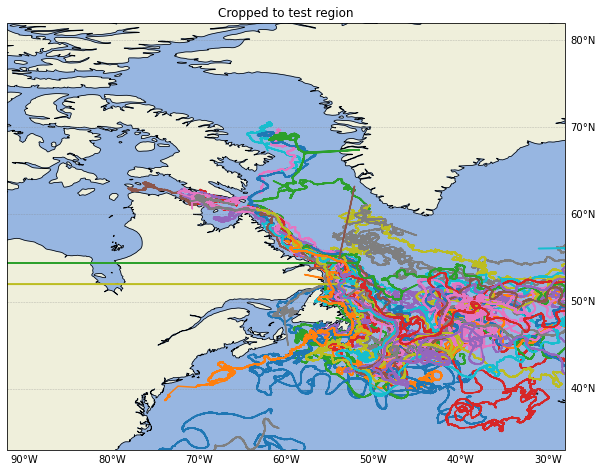

In [5]:
plot_track_points(masterdf, test_region=True)

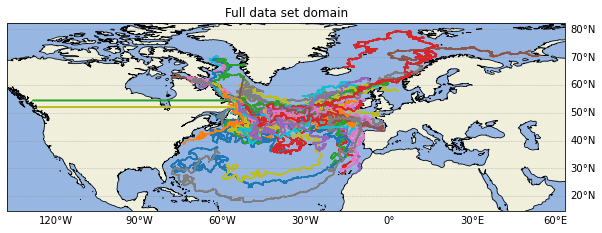

In [6]:
plot_track_points(masterdf, test_region=False)

In [7]:
# There are obviously still some erroneous values in the raw data!

print(np.nanmin(masterdf.LONGITUDE.values), np.nanmax(masterdf.LONGITUDE.values))
print(np.nanmin(masterdf.LATITUDE.values), np.nanmax(masterdf.LATITUDE.values))

-128.2536 54.441
17.7736 79.3332


## Looking at an individual NetCDF file

In [8]:
with xr.load_dataset(ncfile) as nds:
    print_formatted_dataset_info(nds)

Coordinates:
  * TIME     (TIME) datetime64[ns] 2015-07-29T14:30:00 ... 2015-10-22T15:04:00 

Data variables:
    LATITUDE   (TIME) float64 54.96 54.95 54.95 54.94 ... 47.0 47.0 47.0 47.0
    LONGITUDE  (TIME) float64 -54.54 -54.53 -54.53 ... -47.23 -47.23 -47.23

Dimensions
  TIME: 4053

Attributes:
  source: retrieved from ftp.joubeh.com
  description: NAFC drifter data
  buoyid: nafc300234062458690D20150729
  comment: netCDF file created by NAFC Drift Group on 2019-10-01
  approximate_drogue_depth: 15
  model: SVP
  type: SVP
  dataStartDate: 2015-07-29 14:30:00
